In [2]:
%load_ext autoreload
%autoreload 2

#<font color='orange'>Basics</font>

In [3]:
#@title **Location** of the dataset
path =  "../data/HomeCredit/"
process_path = "../data/ProcessedData/"
save_path = "../tests/"
ri_datasets_path = "../data/riData/"

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import secrets
import joblib
import sys
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from scipy.stats import ks_2samp
from lightgbm import LGBMClassifier
from pathlib import Path
from sklearn.metrics import (roc_auc_score)
from sklearn.model_selection import KFold


In [5]:
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                            f1_score, precision_score, recall_score,
                            roc_auc_score, roc_curve)

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.semi_supervised import LabelSpreading

In [7]:
import credit_pipeline.data_exploration as dex
import credit_pipeline.training as tr
import credit_pipeline.reject_inference as ri

from submodules.topsis_python import topsis as top

[x] add kfold

[x] add topsis/ahp multicriterio

[x] add criterio de parada

[-] pip freeze

In [75]:
main_seed = 778888

filepath_param = Path(os.path.join(ri_datasets_path,f'Exp_{main_seed}/params.joblib'))
param_exec = joblib.load(filepath_param)

low_AR = param_exec['low_AR']
high_AR, param_exec['high_AR'] = 96, 96 #param_exec['high_AR']
weights = param_exec['weights']
iterations = param_exec['iterations']
p = param_exec['p']
N_splits = param_exec['N_splits']
seed_number  = param_exec['main_seed']

print(param_exec)

{'low_AR': 3, 'high_AR': 96, 'weights': [1, 10], 'iterations': 5, 'p': 0.1, 'N_splits': 5, 'main_seed': 778888}


In [76]:
filepath_kick = Path(os.path.join(ri_datasets_path,f'Exp_{main_seed}/kickout-{low_AR}_{high_AR}.joblib'))
eval_dict_kick = joblib.load(filepath_kick)

filepath_auc = Path(os.path.join(ri_datasets_path,f'Exp_{main_seed}/auc.joblib'))
eval_dict_auc = joblib.load(filepath_auc)


In [77]:
eval_dict_kick.index = range(low_AR, high_AR+1)
eval_dict_kick

,BM,A-SC,A-UW,A-DW,A-FU,E-C,PAR,LSP,TN,TN+
3,0.0,0.123357,0.052968,0.021654,0.001780,0.025826,-0.000821,0.056637,0.079423,0.032961
4,0.0,0.140066,0.072974,0.046474,0.013310,0.027735,0.020164,0.065867,0.109612,0.048231
5,0.0,0.149476,0.065345,0.066007,0.027754,0.042198,0.034861,0.065406,0.111908,0.039336
6,0.0,0.195165,0.077949,0.072106,0.011017,0.031149,0.016639,0.081470,0.077161,0.049685
7,0.0,0.192453,0.082376,0.071422,0.004894,0.038974,0.014455,0.083140,0.087204,0.048562
...,...,...,...,...,...,...,...,...,...,...
92,0.0,0.901612,0.568532,-0.015477,0.473377,0.177491,0.309885,0.770937,0.463675,0.349017
93,0.0,0.787688,0.712493,-0.088992,0.901129,0.133717,0.072248,0.278193,-0.061111,0.236272
94,0.0,0.620833,1.041508,0.468422,0.384680,0.031153,-0.167712,0.969790,1.069093,0.661688
95,0.0,-0.546503,0.822676,-0.262198,-0.270272,0.118375,-0.127077,0.839947,-0.505634,-0.099530


In [78]:
try:
    eval_dict_auc['CI-EX'] = eval_dict_auc['TN']
    eval_dict_auc['CI-LS'] = eval_dict_auc['TN+']
    eval_dict_auc = eval_dict_auc.drop(['TN','TN+'], axis=1)
except Exception as e:
    pass
df_auc = eval_dict_auc.T

df_auc.insert(0, 'Models', df_auc.index)
df_auc = df_auc.round(3)
df_auc

,Models,Overall AUC
BM,BM,0.714
A-SC,A-SC,0.710
A-UW,A-UW,0.715
A-DW,A-DW,0.716
A-FU,A-FU,0.682
E-C,E-C,0.715
PAR,PAR,0.710
LSP,LSP,0.709
CI-EX,CI-EX,0.711
CI-LS,CI-LS,0.712


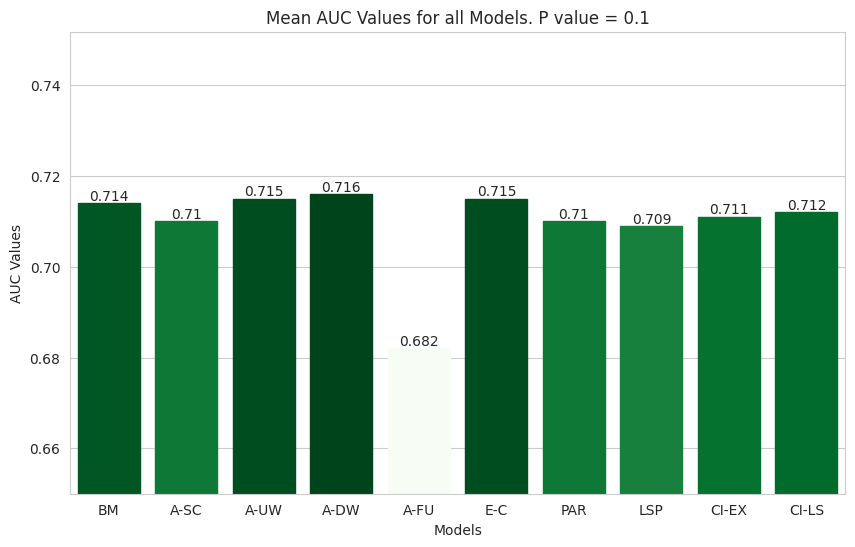

In [79]:
# fig, ax = plt.subplots(figsize=(10, 6))
# plt.plot(eval_dict_auc.columns, eval_dict_auc.T.values )

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))

norm = plt.Normalize(df_auc['Overall AUC'].min(), df_auc['Overall AUC'].max())
sm = plt.cm.ScalarMappable(cmap="Greens", norm=norm)
sm.set_array([])

ax = sns.barplot(data=df_auc, x='Models', y='Overall AUC', estimator=sum, errorbar=None)
for i, bar in enumerate(ax.patches):
    bar.set_color(sm.to_rgba(df_auc['Overall AUC'].iloc[i]))
# lineplot = sns.lineplot(x='Models', y='Overall AUC', data=df_auc, marker='o', color='red', sort=False, label='auc')

# Labeling each bar
ax.bar_label(ax.containers[0], fontsize=10)

ax.set_xlabel('Models')
ax.set_ylabel('AUC Values')
ax.set_title(f'Mean AUC Values for all Models. P value = {p}')
# ax.legend()
plt.ylim(bottom=0.65)

plt.savefig(f'{ri_datasets_path}Exp_{main_seed}/mean_auc_{main_seed}',  dpi=150)
plt.show()


In [14]:
eval_dict = eval_dict_3_94.copy()

In [15]:
eval_dict['CI-EX'] = eval_dict['TN']
eval_dict['CI-LS'] = eval_dict['TN+']
eval_dict = eval_dict.drop(['TN','TN+'], axis=1)

In [16]:
eval_dict

,BM,A-SC,A-UW,A-DW,A-FU,E-C,PAR,LSP,CI-EX,CI-LS
3,0.0,0.072674,0.047170,0.063353,0.020044,0.025237,0.020441,0.066937,0.101566,0.029379
4,0.0,0.129729,0.059358,0.067167,0.019901,0.026707,0.029790,0.072648,0.086293,0.035513
5,0.0,0.139327,0.075769,0.062098,0.006790,0.029590,0.007161,0.082628,0.112127,0.015980
6,0.0,0.153969,0.064651,0.046637,0.005489,0.042890,0.024973,0.087566,0.130745,0.025366
7,0.0,0.142596,0.061184,0.047468,0.005346,0.035187,0.022467,0.104209,0.145433,0.042911
...,...,...,...,...,...,...,...,...,...,...
90,0.0,0.645506,1.031664,0.635368,0.622505,0.645410,0.282132,0.585029,-0.216738,0.240276
91,0.0,0.883645,0.980117,1.085837,0.919824,0.765673,0.883099,0.938701,0.467358,0.432754
92,0.0,0.455422,0.946665,0.922978,1.023515,0.622841,1.221446,0.789995,0.327655,0.626338
93,0.0,0.356134,0.722441,1.381890,1.144374,0.187816,1.256293,0.530747,0.290519,0.667909


In [43]:
# eval_dict = eval_dict.drop('A-SC', axis=1)

In [52]:
# eval_dict = eval_dict.loc[[10,20,30,40,50,60,70,80,90],:]

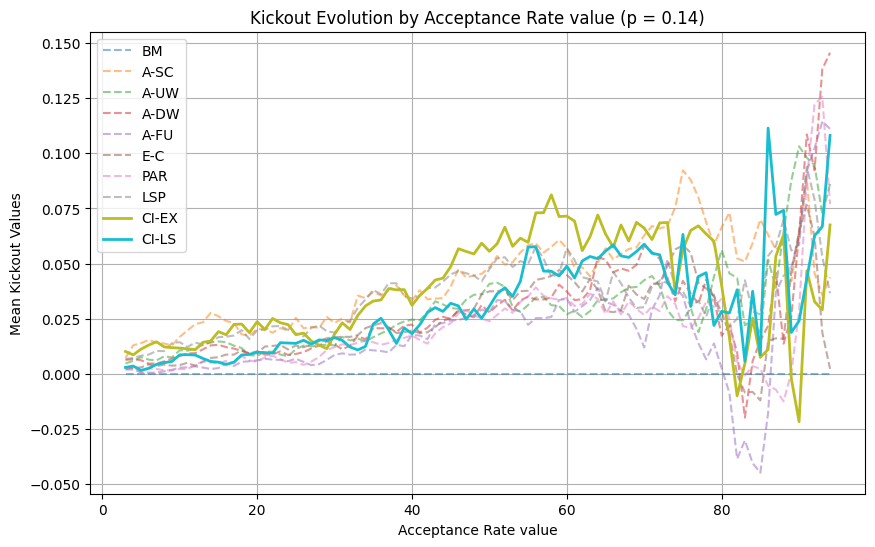

In [18]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plot all metrics
for column in eval_dict.columns:
    if column in ['CI-EX', 'CI-LS']:
        # Highlighting "TN" and "TN+" columns
        ax.plot(eval_dict.index, eval_dict[column]/10, label=column, linewidth=2)
    else:
        # Plot other metrics with a less prominent style
        ax.plot(eval_dict.index, eval_dict[column]/10, label=column, linestyle='--', alpha=0.5)

# Customization
ax.set_xlabel('Acceptance Rate value')
ax.set_ylabel('Mean Kickout Values')
ax.set_title(f'Kickout Evolution by Acceptance Rate value (p = {p})')
ax.legend()
plt.grid(True)

plt.savefig(f'{ri_datasets_path}Exp_{main_seed}/all_kick_by_AR_{seed_number}',  dpi=150)

plt.show()




In [56]:
import seaborn as sns

In [169]:
eval_dict.T

,10,11,12,13,14,15,16,17,18,19,...,81,82,83,84,85,86,87,88,89,90
BM,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A-SC,0.175214,0.184542,0.199933,0.237273,0.219625,0.240319,0.219835,0.227419,0.229905,0.221103,...,0.993547,0.868113,1.067908,0.814644,0.681943,0.834135,0.741103,0.700449,0.214598,0.000866
A-UW,0.067531,0.101242,0.121230,0.158218,0.151971,0.127285,0.132480,0.134535,0.132397,0.126168,...,0.487973,0.776019,0.734349,0.653111,0.921659,0.816551,1.160683,0.928258,0.745882,0.629871
A-DW,0.078042,0.091265,0.096396,0.138766,0.137531,0.134766,0.132018,0.118493,0.120286,0.121428,...,0.629634,0.585181,0.514240,0.670414,0.933919,0.877570,0.912813,1.064513,0.516291,0.516148
A-FU,0.031670,0.050257,0.050103,0.046893,0.080384,0.075031,0.081267,0.087636,0.087372,0.105481,...,0.154602,0.291365,0.404451,0.648892,0.681473,0.762826,1.083871,0.709022,0.695245,0.756401
E-C,0.048456,0.060121,0.081495,0.076600,0.097758,0.094388,0.090763,0.099368,0.120404,0.135379,...,0.371064,0.299803,0.202905,0.197358,0.256935,0.476272,0.311623,0.169651,0.633268,0.702721
PAR,0.044253,0.063027,0.055749,0.052584,0.065467,0.054765,0.071587,0.076147,0.083295,0.093982,...,0.629218,0.778800,0.855442,0.884696,0.696132,0.894066,0.985457,1.281153,0.950674,0.978746
LSP,0.150925,0.167036,0.183703,0.188721,0.192331,0.202507,0.230681,0.243429,0.246666,0.281544,...,0.930061,0.938016,0.904342,0.803200,0.706136,0.537177,0.744104,0.817370,0.943488,0.396018
CI-EX,0.158579,0.200929,0.215034,0.270502,0.246180,0.266105,0.294694,0.327893,0.319354,0.307771,...,0.639598,1.046796,1.124294,0.826176,1.027028,0.912620,1.250215,0.989478,1.253668,0.392644
CI-LS,0.083692,0.094140,0.138960,0.111558,0.133101,0.146026,0.118280,0.174492,0.200428,0.247351,...,1.126248,0.963610,0.904934,0.683164,1.012423,0.771247,1.255134,1.218245,0.742451,0.740462


In [170]:
k_50 = eval_dict.loc[50,:]

In [171]:
k_50

BM       0.000000
A-SC     0.464135
A-UW     0.173578
A-DW     0.315494
A-FU     0.198351
E-C      0.247762
PAR      0.224465
LSP      0.565434
CI-EX    0.751782
CI-LS    0.709050
Name: 50, dtype: float64

In [172]:
df = pd.DataFrame([k_50.index, k_50.values])
df = df.T

In [173]:
df

,0,1
0,BM,0.0
1,A-SC,0.464135
2,A-UW,0.173578
3,A-DW,0.315494
4,A-FU,0.198351
5,E-C,0.247762
6,PAR,0.224465
7,LSP,0.565434
8,CI-EX,0.751782
9,CI-LS,0.70905


In [190]:
eval_dict_auc['CI-EX'] = eval_dict_auc['TN']
eval_dict_auc['CI-LS'] = eval_dict_auc['TN+']
eval_dict_auc = eval_dict_auc.drop(['TN', 'TN+'],axis=1)

In [193]:
da = eval_dict_auc.T
da['model'] = da.index

In [219]:
da['kickout'] = df[1].values/10


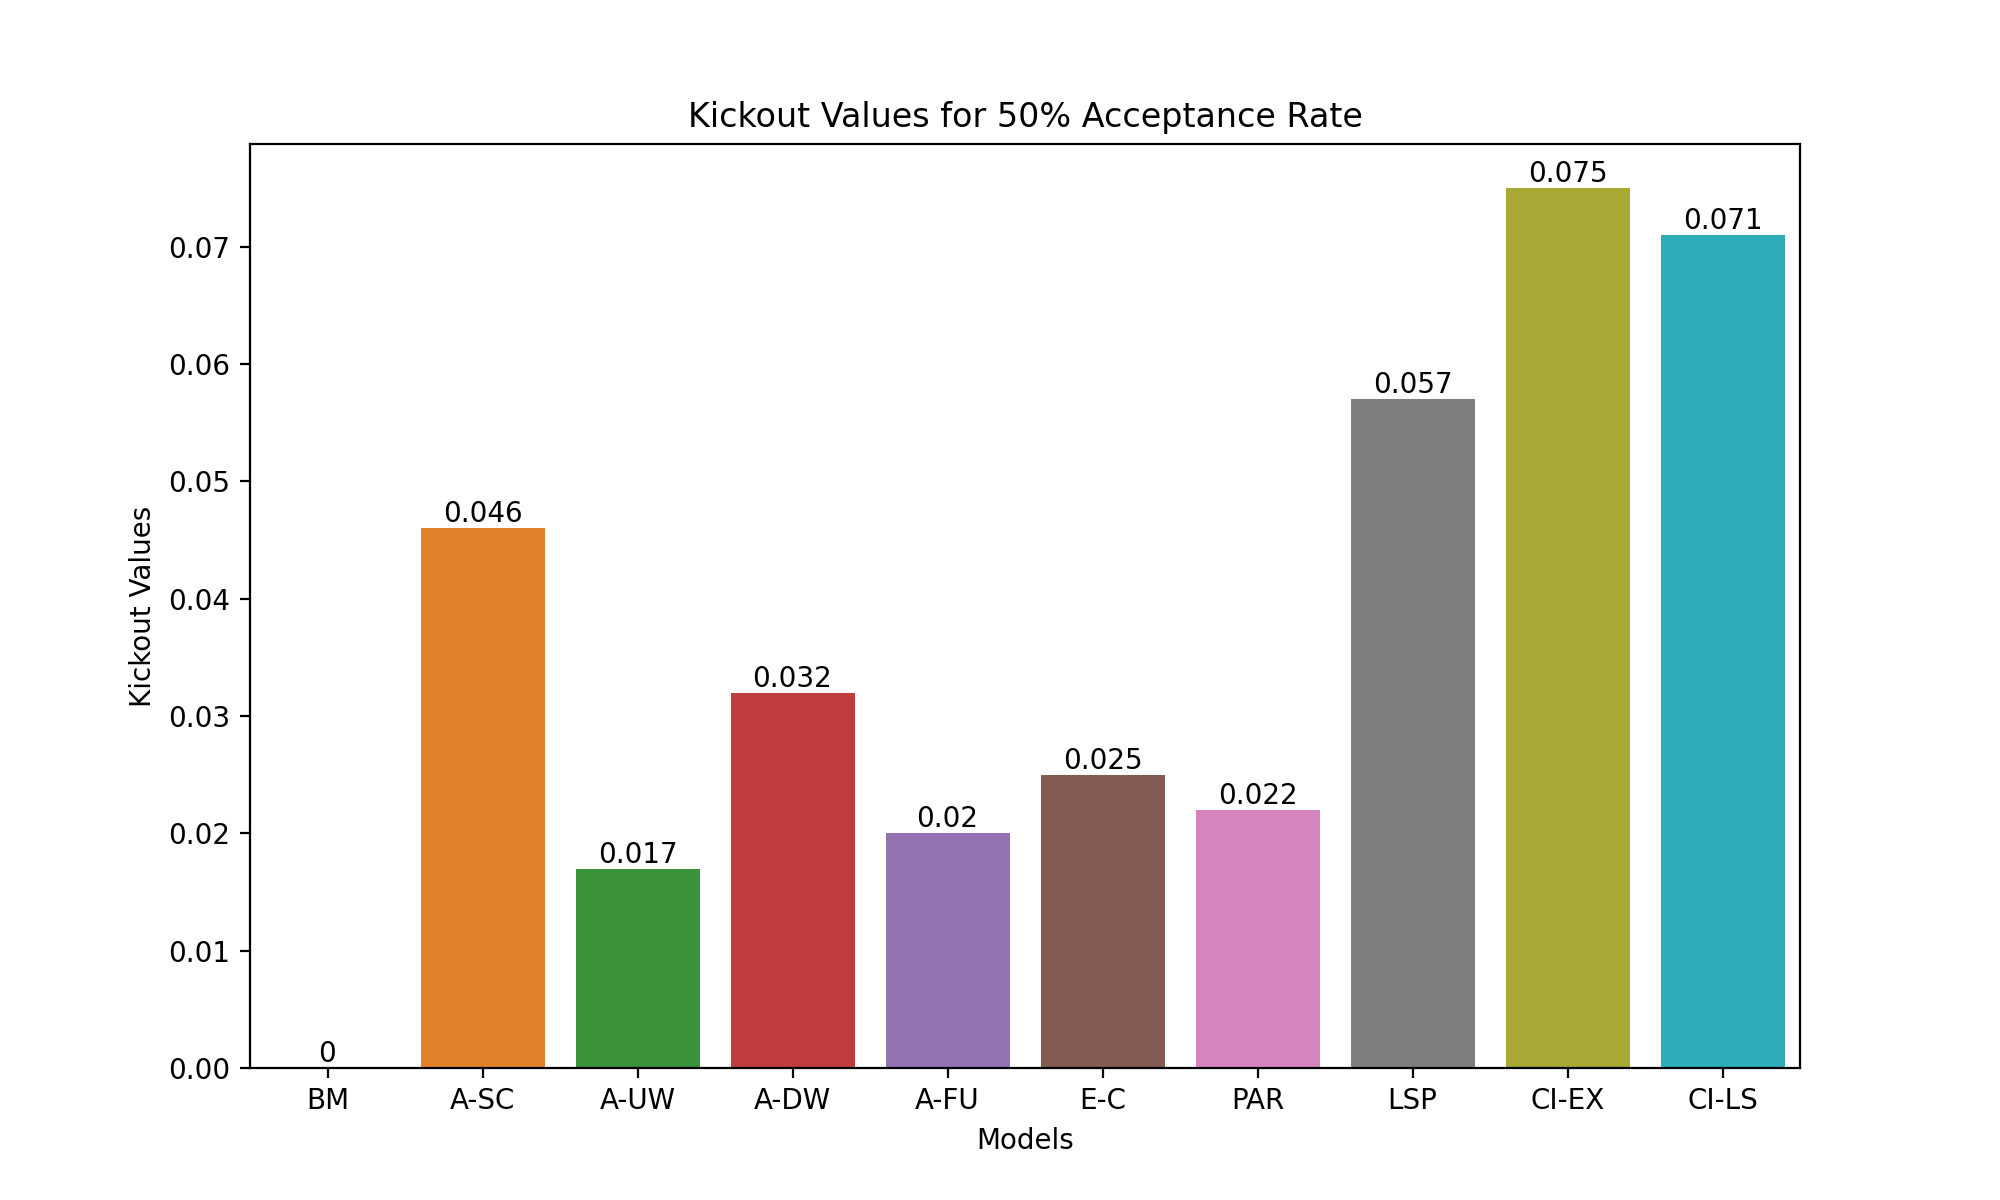

In [222]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=da, x='model', y='kickout', estimator=sum, errorbar=None)

# Labeling each bar
ax.bar_label(ax.containers[0], fontsize=10)

ax.set_xlabel('Models')
ax.set_ylabel('Kickout Values')
ax.set_title('Kickout Values for 50% Acceptance Rate')
# ax.legend()

plt.savefig(f'kick_for_ar_50_{13582}',  dpi=150)
plt.show()


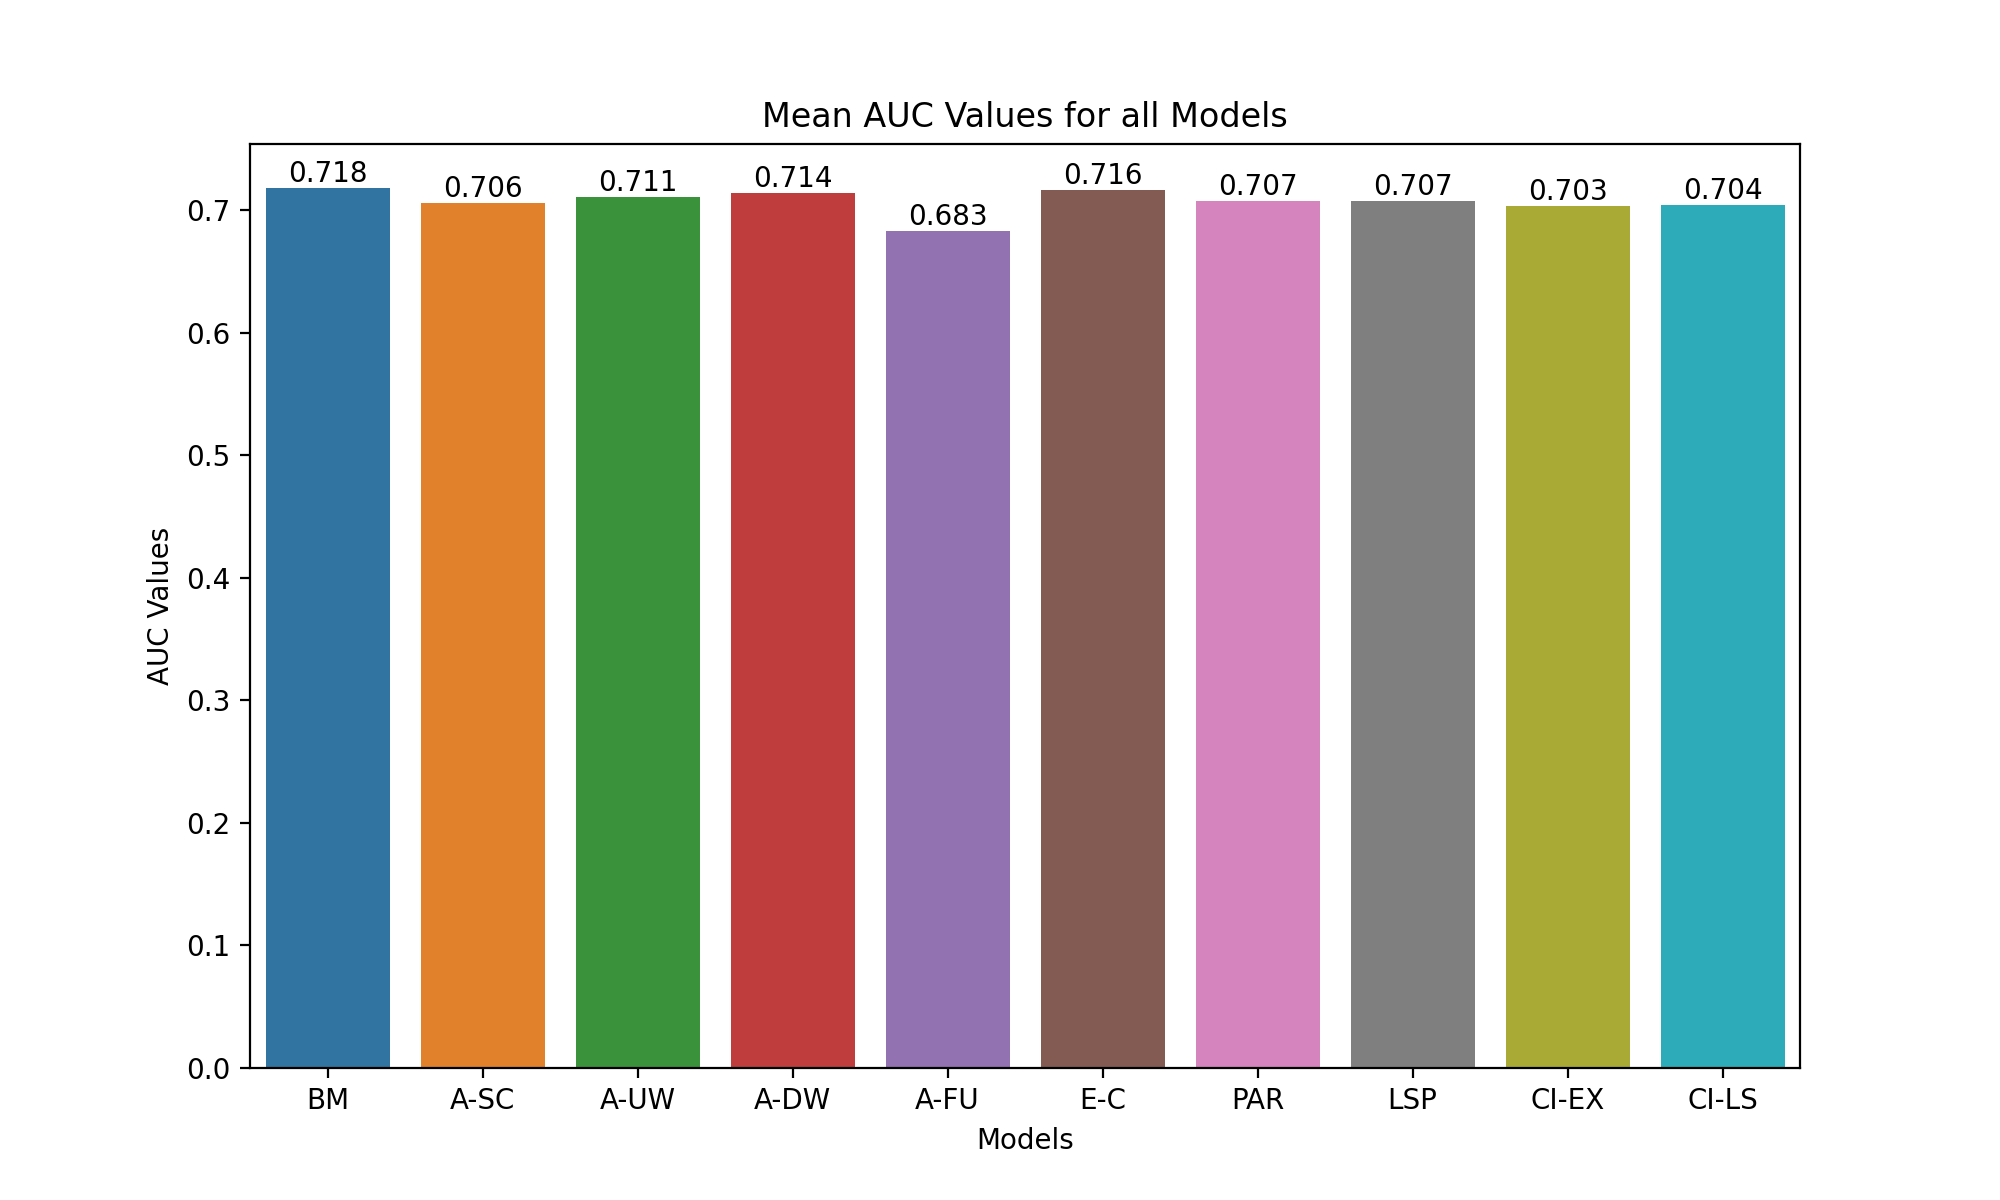

In [225]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Plotting
# plt.figure(figsize=(10, 6))
# ax = sns.barplot(data=da, x='model', y='Overall AUC', estimator=sum, errorbar=None)

# # Labeling each bar
# ax.bar_label(ax.containers[0], fontsize=10)

# ax.set_xlabel('Models')
# ax.set_ylabel('AUC Values')
# ax.set_title('Mean AUC Values for all Models')
# # ax.legend()

# plt.savefig(f'auc_{13582}',  dpi=150)
# plt.show()


In [129]:
dd = da.copy()

In [223]:
da['kickout'] = pd.to_numeric(da['kickout'], errors='coerce')
da['Overall AUC'] = pd.to_numeric(da['Overall AUC'], errors='coerce').round(3)

In [224]:
da['kickout'] = da['kickout'].round(3)
da

,Overall AUC,model,kickout
BM,0.718,BM,0.000
A-SC,0.706,A-SC,0.046
A-UW,0.711,A-UW,0.017
A-DW,0.714,A-DW,0.032
A-FU,0.683,A-FU,0.020
E-C,0.716,E-C,0.025
PAR,0.707,PAR,0.022
LSP,0.707,LSP,0.057
CI-EX,0.703,CI-EX,0.075
CI-LS,0.704,CI-LS,0.071


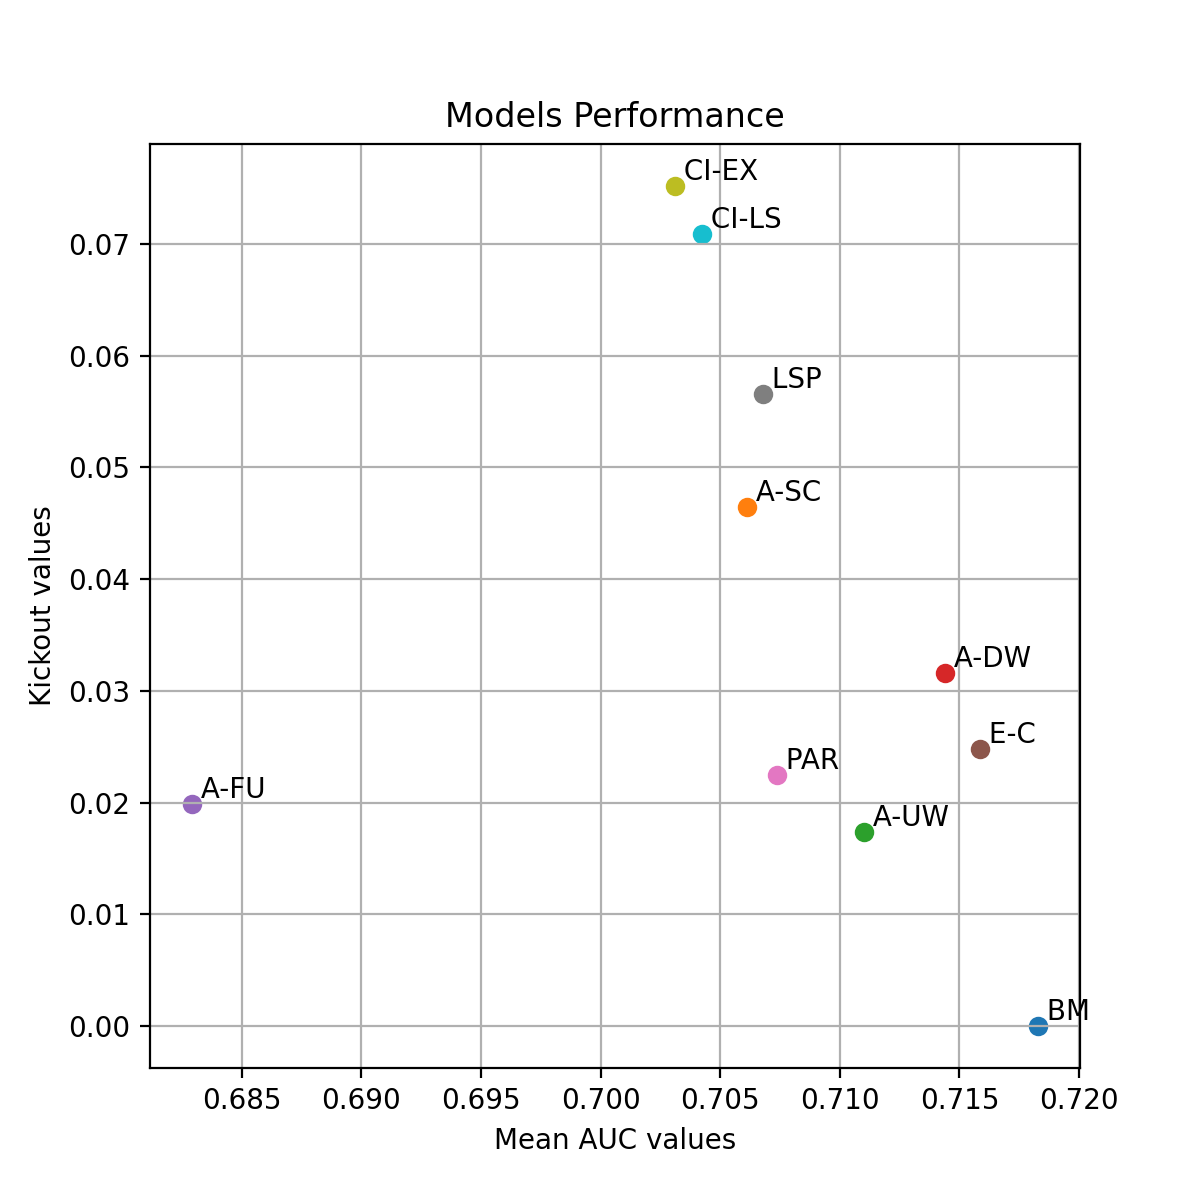

In [215]:
import matplotlib.pyplot as plt
import pandas as pd

# Creating the plot
plt.figure(figsize=(6, 6))
for _, row in da.iterrows():

    plt.scatter(row['Overall AUC'], row['kickout'], label=row['model'])
    plt.text(row['Overall AUC'], row['kickout'], f" {row['model']}", verticalalignment='bottom')

# Customizing the plot
plt.xlabel('Mean AUC values')
plt.ylabel('Kickout values')
plt.title('Models Performance')
plt.grid(True)

plt.savefig(f'auc_x_kickout_{13582}',  dpi=500)
plt.show()

In [7]:
#@title Read dataset
df_o = pd.read_csv(path+'application_train.csv')    #HomeCredit training dataset

In [8]:
#@title Create develoment train and test
df_train, df_test = tr.create_train_test(df_o, seed=43)

In [9]:
#@title Set seed
new_seed = False #@param {type:"boolean"}

if new_seed:
    seed_number = secrets.randbelow(1_000) #to name the results files

    while seed_number <100:
        seed_number = secrets.randbelow(1_000)
else:
    seed_number = 1000

main_seed = seed_number

print(seed_number)

1000


In [11]:
len(ri.cherry_cols)

71

In [30]:
ll = []

for i, c in enumerate(df_o.columns):
    if c not in ri.cherry_cols and c not in ri.cols_RI:
        ll.append(c)

In [26]:
np.array(ll)

array(['SK_ID_CURR', 'TARGET', 'CODE_GENDER', 'AMT_ANNUITY',
       'NAME_FAMILY_STATUS', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'OCCUPATION_TYPE', 'REG_REGION_NOT_LIVE_REGION',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_4',
       'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7',
       'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10',
       'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13',
       'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16',
       'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19',
       'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21'], dtype='<U26')

In [31]:
column_description(df_o, ll)

ValueError: ('Shapes must match', (122,), (37,))

In [32]:
def column_description(dataframe, column_name):

    df_desc = dex.read_csv_encoded(path,'HomeCredit_columns_description.csv')
    #Create dataframe with columns and descriptions
    descriptions = df_desc.query("Table == 'application_{train|test}.csv'")[['Row','Description']].T
    desc = (descriptions.iloc[:,dataframe.columns == column_name].values)
    return f'{desc[1][0]}'

desc_dict = {}
for ci in ll:
    desc_dict[ci] = column_description(df_o, ci)

In [33]:
desc_dict

{'SK_ID_CURR': 'ID of loan in our sample',
 'TARGET': 'Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)',
 'CODE_GENDER': 'Gender of the client',
 'AMT_ANNUITY': 'Loan annuity',
 'NAME_FAMILY_STATUS': 'Family status of the client',
 'DAYS_REGISTRATION': 'How many days before the application did client change his registration',
 'DAYS_ID_PUBLISH': 'How many days before the application did client change the identity document with which he applied for the loan',
 'FLAG_WORK_PHONE': 'Did client provide home phone (1=YES, 0=NO)',
 'FLAG_CONT_MOBILE': 'Was mobile phone reachable (1=YES, 0=NO)',
 'FLAG_PHONE': 'Did client provide home phone (1=YES, 0=NO)',
 'FLAG_EMAIL': 'Did client provide email (1=YES, 0=NO)',
 'OCCUPATION_TYPE': 'What kind of occupation does the client have',
 'REG_REGION_NOT_LIVE_REGION': "Flag if client's permanent address does not ma

In [ ]:
pd.DataFrame(desc_dict, index=['desc']).T

,desc
AMT_CREDIT,Credit amount of the loan
EXT_SOURCE_1,Normalized score from external data source
EXT_SOURCE_2,Normalized score from external data source
EXT_SOURCE_3,Normalized score from external data source
REGION_POPULATION_RELATIVE,Normalized population of region where client l...
DAYS_EMPLOYED,How many days before the application the perso...
DAYS_BIRTH,Client's age in days at the time of application
AMT_INCOME_TOTAL,Income of the client
CNT_CHILDREN,Number of children the client has
CNT_FAM_MEMBERS,How many family members does client have


In [14]:
dex.check_missing(df_o,50,True)

,MISSING,PERCENTAGE_MISSING
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_AVG,213514,69.432963
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_MEDI,210199,68.354953
LIVINGAPARTMENTS_MODE,210199,68.354953
LIVINGAPARTMENTS_AVG,210199,68.354953


In [34]:
dex.describe_data(df_o,ll)

,mean,median,mode,unbalanced_ratio,qtd_unique,qtd_null,data_type
SK_ID_CURR,278180.518577,278202.0,100002,0.000003,307511,0,int64
TARGET,0.080729,0.0,0,0.919271,2,0,int64
CODE_GENDER,NaN,NaN,F,0.658344,3,0,object
AMT_ANNUITY,27108.573909,24903.0,9000.0,0.020764,13673,12,float64
NAME_FAMILY_STATUS,NaN,NaN,Married,0.638780,6,0,object
DAYS_REGISTRATION,-4986.120328,-4504.0,-1.0,0.000367,15688,0,float64
DAYS_ID_PUBLISH,-2994.202373,-3254.0,-4053,0.000550,6168,0,int64
FLAG_WORK_PHONE,0.199368,0.0,0,0.800632,2,0,int64
FLAG_CONT_MOBILE,0.998133,1.0,1,0.998133,2,0,int64
FLAG_PHONE,0.281066,0.0,0,0.718934,2,0,int64


#Params

In [11]:
params_dict = ri.params_dict

In [12]:
params_dict['LightGBM_2'] = {'boosting_type': 'gbdt', 'class_weight': None,
              'colsample_bytree': 0.22534977954592625, 'importance_type': 'split',
              'learning_rate': 0.052227873762946964, 'max_depth': 5,
              'min_child_samples': 26, 'min_child_weight': 0.001,
              'min_split_gain': 0.0, 'n_estimators': 159, 'n_jobs': -1,
              'num_leaves': 12, 'objective': None, 'random_state': seed_number,
              'reg_alpha': 0.7438345471808012, 'reg_lambda': 0.46164693905368515,
                'verbose': -1, 'subsample': 0.8896599304061413,
              'subsample_for_bin': 200000, 'subsample_freq': 0,
              'is_unbalance': True}

#<font color='orange'>Helper Functions</font>


#<font color='red'>Definition of Train and Test Val, and Unl</font>

In [14]:
params_dict['LightGBM_2'].update({'random_state': seed_number})
#--------------Create dataset with Approved and Rejected---------------
X_train_ls, y_train_ls, X_unl_ls = X_train_acp.copy(), y_train_acp.copy(), X_train_rej.copy()

X_combined = pd.concat([X_train_ls, X_unl_ls])

y_unl_ls = np.array([-1]*X_unl_ls.shape[0])
y_combined = np.concatenate([y_train_ls.array, y_unl_ls])
y_combined = pd.Series(y_combined, index=X_combined.index)

n_labeled_points = y_train_ls.shape[0]
indices = np.arange(y_combined.shape[0])

#--------------Predict labels on the unlabeled data---------------
lp_model = tr.create_pipeline(X_combined, y_combined, LabelSpreading(**params_dict['LabelSpreading_2']))
lp_model.fit(X_combined, y_combined)
predicted_labels = lp_model['classifier'].transduction_[indices[n_labeled_points:]]

y_label_pred_s = pd.Series(predicted_labels, index=X_unl_ls.index)

new_X_train = pd.concat([X_train_ls, X_unl_ls])
new_y_train = pd.concat([y_train_ls, y_label_pred_s])

clf_LS = tr.create_pipeline(new_X_train, new_y_train, LGBMClassifier(**params_dict['LightGBM_2']))
clf_LS.fit(new_X_train, new_y_train,)

#--------------Fit classifier---------------
#Create a new classifier pipeline using labeled and unlabeled data, and fit it


Pipeline(steps=[('fill',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['AMT_CREDIT', 'EXT_SOURCE_1',
                                                   'EXT_SOURCE_2',
                                                   'EXT_SOURCE_3',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_EMPLOYED',
                                                   'DAYS_BIRTH',
                                                   'AMT_INCOME_TOTAL',
                                                   'CNT_CHILDREN',
                                                   'CNT_FAM_MEMBERS',
                                                   'REG_CITY_NOT_WORK_CITY',
                                                   'AMT_GOODS_PRICE']),
                                                 ('cat',
                                                  Pipeline(steps=[('im...
                                                   'NAME_CONTRACT_TYPE'])],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 LGBMClassifier(colsample_bytree=0.22534977954592625,
                                is_unbalance=True,
                                learning_rate=0.052227873762946964, max_depth=5,
                                min_child_samples=26, n_estimators=159,
                                n_jobs=-1, num_leaves=12, random_state=1000,
                                reg_alpha=0.7438345471808012,
                                reg_lambda=0.46164693905368515,
                                subsample=0.8896599304061413, verbose=-1))])

In [15]:
from scipy import stats
# lp_model['classifier'].transduction_[indices[n_labeled_points:]]
pred_entropies = stats.distributions.entropy(lp_model['classifier'].label_distributions_.T)


In [57]:
k = y_combined[y_combined == -1]

In [77]:
np.set_printoptions(suppress = True)

In [78]:
pred_entropies = stats.distributions.entropy(
    lp_model['classifier'].label_distributions_[:20].T)

In [79]:
pred_entropies

array([0.00779122, 0.0000342 , 0.00009047, 0.00098599, 0.        ,
       0.00042674, 0.00016781, 0.00069749, 0.01717163, 0.020069  ,
       0.00319913, 0.00440617, 0.00001415, 0.00039972, 0.00015737,
       0.00229545, 0.00018379, 0.00599039, 0.34016916, 0.00279278])

In [85]:
pred_entropies[np.argpartition(pred_entropies, 10)[:10]]

array([0.0000342 , 0.00018379, 0.00009047, 0.00015737, 0.        ,
       0.00042674, 0.00016781, 0.00039972, 0.00001415, 0.00069749])

In [88]:
y_combined.iloc[np.argpartition(pred_entropies, 10)[:10]]

245371    0
232597    0
296465    0
189661    0
295502    0
283562    0
122268    0
293693    0
269638    0
185231    0
dtype: int64

In [89]:
y_combined.iloc[np.argpartition(pred_entropies, -10)[-10:]]

117447    0
120410    0
185296    0
217563    0
266898    0
213417    0
303199    0
304316    0
276521    1
155284    0
dtype: int64

In [91]:
pred_entropies[np.argpartition(pred_entropies, -10)[-10:]]

array([0.00098599, 0.00229545, 0.00279278, 0.00319913, 0.00440617,
       0.00599039, 0.00779122, 0.01717163, 0.34016916, 0.020069  ])

In [153]:
np.sort(pred_entropies[y_combined == 0])

array([0.        , 0.        , 0.        , ..., 0.47964688, 0.50489934,
       0.51239301])

In [160]:
lp_model['classifier'].transduction_[y_combined == -1].shape

(119443,)

In [152]:
np.sort(lp_model['classifier'].label_distributions_[y_combined,1][y_combined == 0])

(36169,)

In [120]:
lp_model['classifier'].label_distributions_[indices[:n_labeled_points],1][y_train_ls == 0].sum()

143.93023478374255

In [123]:
y_train_ls[y_train_ls == 1].shape

(1833,)

In [164]:
lp_model['classifier'].label_distributions_[y_combined == -1][:,1]

array([0.10675477, 0.0030983 , 0.02824937, ..., 0.00221102, 0.00078112,
       0.00172837])

In [69]:
dex.get_shapes(new_X_train, X_train_ls, X_unl_ls, X_combined, predicted_labels)

new_X_train : (157445, 15)
X_train_ls : (38002, 15)
X_unl_ls : (119443, 15)
X_combined : (157445, 15)
predicted_labels : (119443,)


In [132]:
lp_model['classifier'].label_distributions_[:,1][y_combined == 0].sum()

143.93023478374255

In [37]:
uncertainty_index = np.argsort(pred_entropies)[-10:]

In [38]:
pred_entropies[uncertainty_index]

array([0.69314706, 0.69314707, 0.69314711, 0.69314714, 0.69314714,
       0.69314716, 0.69314717, 0.69314717, 0.69314718, 0.69314718])

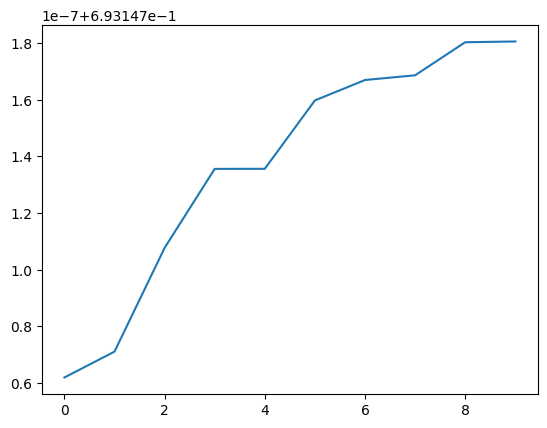

In [41]:
plt.plot(pred_entropies[uncertainty_index])

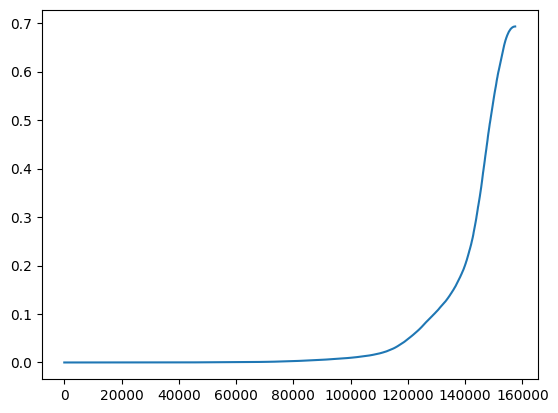

In [24]:
plt.plot(sorted(pred_entropies))

In [13]:
N_splits=5
kf = KFold(n_splits=N_splits)   #80-20 split for train-test
hist_dict = {}
data_dict = {}

for fold_number, (train_index, test_index) in enumerate(kf.split(df_o)):
    #diferent seed for each iteration
    seed_number = main_seed+fold_number

    df_train = df_o.iloc[train_index]
    df_test = df_o.iloc[test_index]
    
    val_split = int(df_train.shape[0] * 0.2)  #80-20 split for train-validation
    df_val = df_train.iloc[:val_split]
    df_train = df_train.iloc[val_split:]

    df_train, policy_model = ri.fit_policy(df_train)

    X_train, X_test, X_val = df_train, df_test, df_val
    y_train, y_test, y_val = df_train["TARGET"], df_test["TARGET"], df_val["TARGET"]

    X_train_acp, X_train_rej, y_train_acp, y_train_rej = ri.accept_reject_split(X_train, y_train, policy_clf=policy_model)
    X_test_acp, X_test_rej, y_test_acp, y_test_rej = ri.accept_reject_split(X_test, y_test, policy_clf=policy_model)
    X_val_acp, X_val_rej, y_val_acp, y_val_rej = ri.accept_reject_split(X_val, y_val, policy_clf=policy_model)
    
    data_dict[fold_number] = [X_train_acp, X_train_rej, y_train_acp, y_train_rej,
                               X_test_acp, X_test_rej, y_test_acp,
                               X_val_acp, X_val_rej, y_val_acp]
    break
    # dex.get_shapes(X_train_acp, X_train_rej, X_test_acp, X_test_rej, X_val_acp, X_val_rej)

    # metrics = ri.get_metrics_RI(datasets, X_test_acp, y_test_acp, X_val_acp, y_val_acp, X_test_rej)
    # break
    models_dict = {}

    benchmark = tr.create_pipeline(X_train_acp, y_train_acp,
                                  LGBMClassifier(**params_dict['LightGBM_2']))
    benchmark.fit(X_train_acp, y_train_acp)

    
    models_dict['BM'] = benchmark

    models_dict.update(
        ri.augmentation_with_soft_cutoff(X_train_acp, y_train_acp, X_train_rej, seed = seed_number))
    models_dict.update(
        ri.augmentation(X_train_acp, y_train_acp, X_train_rej, mode='up', seed = seed_number))
    models_dict.update(
        ri.augmentation(X_train_acp, y_train_acp, X_train_rej, mode='down', seed = seed_number))
    models_dict.update(
        ri.fuzzy_augmentation(X_train_acp, y_train_acp, X_train_rej, seed = seed_number))
    models_dict.update(
        ri.extrapolation(X_train_acp, y_train_acp, X_train_rej, seed = seed_number))
    models_dict.update(
        ri.parcelling(X_train_acp, y_train_acp, X_train_rej, seed = seed_number))
    models_dict.update(
        ri.label_spreading(X_train_acp, y_train_acp, X_train_rej, seed = seed_number))
    models_dict.update(
        ri.trusted_non_outliers(X_train_acp, y_train_acp, X_train_rej,
                                 X_val_acp, y_val_acp, iterations=100,p = 0.07, output=-1,
                                 seed=seed_number, technique= 'LS'))
    
    hist_dict[fold_number] = models_dict
    # metrics_dict[fold_number] = ri.get_metrics_RI(models_dict, X_test_acp, y_test_acp, X_val_acp, y_val_acp, X_test_rej)
    print(fold_number)
    # break

In [ ]:
# main_seed = 7777
seed_number = main_seed

In [ ]:
for fold_number in range(N_splits):
    print(seed_number+fold_number)

7777
7778
7779
7780
7781


In [ ]:
metrics_dict = {}
for fold_number in range(N_splits):
    X_train_acp, X_train_rej, y_train_acp, y_train_rej,X_test_acp, X_test_rej, y_test_acp,X_val_acp, X_val_rej, y_val_acp = data_dict[fold_number]

    seed_number = seed_number+fold_number
    filepath = Path(os.path.join(ri_datasets_path,f'TN-{seed_number}.joblib'))
    datasets = joblib.load(filepath)


    values = ri.get_metrics_RI(datasets, X_val_acp, y_val_acp, X_unl = X_test_rej, threshold_type='none', 
                            acp_rate=0.05).loc[
                                ["Overall AUC", "Kickout"]].T.to_numpy()
    weights = [10,1]
    criterias = np.array([True, True])
    t = top.Topsis(values, weights, criterias)
    t.calc()
    output = t.rank_to_best_similarity()[0] - 1
    print(f'best iteration: {output}')

    hist_dict[fold_number]['TN'] = datasets[f'TN_{output}']
    # break

best iteration: 18


In [ ]:
metrics_dict = {}
for fold_number in range(N_splits):
    X_train_acp, X_train_rej, y_train_acp, y_train_rej,X_test_acp, X_test_rej, y_test_acp,X_val_acp, X_val_rej, y_val_acp = data_dict[fold_number]

    metrics_dict[fold_number] = ri.get_metrics_RI(hist_dict[fold_number], X_test_acp, y_test_acp, X_val_acp, y_val_acp, X_test_rej, acp_rate=0.8)
    # break
mean_metrics = sum([metrics_dict[i] for i in range(N_splits)])/N_splits
mean_metrics

    

KeyError: 1

In [ ]:
metrics_dict[0]

,BM,A-SC,A-UW,A-DW,A-FU,E-C,PAR,LSP,TN
Overall AUC,0.729578,0.719508,0.727736,0.729200,0.707533,0.732998,0.730035,0.717336,0.715241
KS,0.338677,0.326551,0.346592,0.339654,0.317456,0.345958,0.333673,0.322026,0.319460
Balanced Accuracy,0.664787,0.662688,0.663577,0.668605,0.641827,0.659472,0.659542,0.656765,0.647841
Accuracy,0.744570,0.719697,0.709104,0.643738,0.747586,0.725865,0.794784,0.674041,0.749195
Precision,0.107853,0.101687,0.099889,0.091217,0.101289,0.102017,0.121626,0.092417,0.103612
Recall,0.576294,0.599455,0.613079,0.696185,0.524523,0.585831,0.509537,0.637602,0.535422
F1,0.181701,0.173879,0.171789,0.161301,0.169791,0.173772,0.196377,0.161435,0.173625
Approval Rate,0.899973,0.890386,0.892733,0.891191,0.866452,0.900979,0.894543,0.898901,0.902990
Kickout,0.000000,1.367951,0.235145,0.866112,0.602628,0.580068,0.958923,1.475527,1.508268
KG,0.000000,473.000000,90.000000,143.000000,141.000000,68.000000,36.000000,282.000000,352.000000


In [ ]:
metric = mean_metrics.loc[['Overall AUC', 'Kickout', 'Approval Rate']]

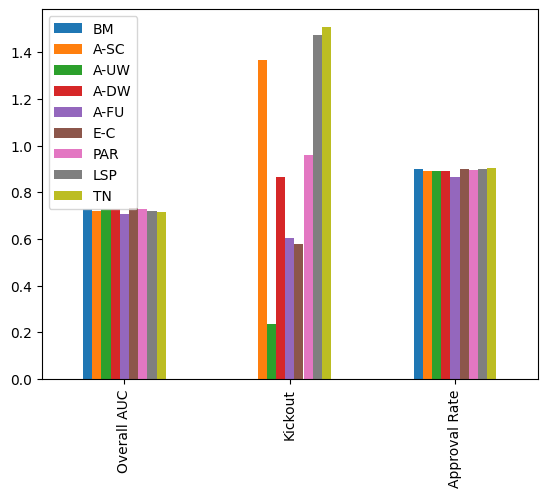

In [ ]:
metric.plot.bar()
plt.show()

In [ ]:
metrics = ri.get_metrics_RI(datasets, X_test_acp, y_test_acp, X_val_acp, y_val_acp, X_test_rej, acp_rate=0.8)

In [ ]:
cols = ['Overall AUC','Kickout',]

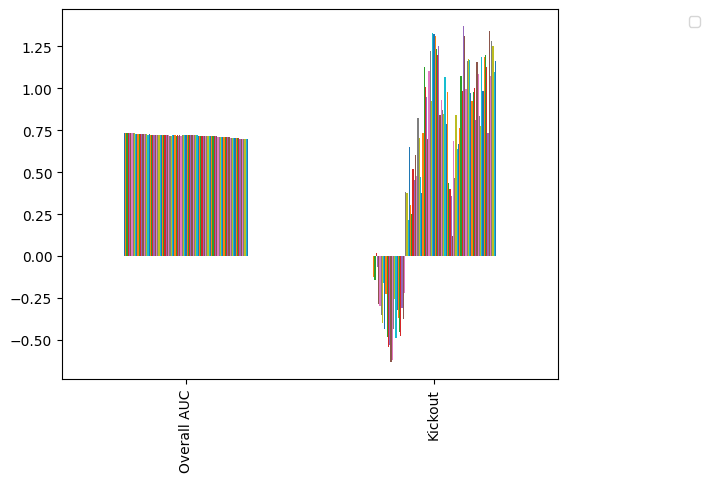

In [ ]:
metrics.loc[cols].plot.bar().legend([], loc='upper right', bbox_to_anchor=(.8, 0.5, 0.5, 0.5))

In [ ]:
metrics

,BM,TN_1,TN_2,TN_3,TN_4,TN_5,TN_6,TN_7,TN_8,TN_9,...,TN_91,TN_92,TN_93,TN_94,TN_95,TN_96,TN_97,TN_98,TN_99,TN_100
Overall AUC,0.732601,0.733048,0.733122,0.733048,0.732306,0.732120,0.729975,0.730628,0.730495,0.730218,...,0.705715,0.704575,0.703788,0.702120,0.701675,0.700258,0.700068,0.698581,0.698365,0.695927
KS,0.362753,0.360955,0.356273,0.357491,0.354289,0.353183,0.347506,0.356078,0.352652,0.354083,...,0.312758,0.305102,0.302152,0.301541,0.300287,0.299767,0.305850,0.301295,0.300491,0.295525
Balanced Accuracy,0.680909,0.676548,0.670136,0.669017,0.669549,0.672294,0.667299,0.670670,0.673198,0.674368,...,0.654546,0.651736,0.646211,0.649040,0.644336,0.648381,0.644410,0.647357,0.641858,0.641945
Accuracy,0.667227,0.690068,0.657910,0.684439,0.696668,0.688192,0.626335,0.626529,0.633840,0.643546,...,0.696732,0.656487,0.716985,0.677515,0.676027,0.663798,0.684892,0.681786,0.704950,0.697638
Precision,0.093220,0.095721,0.089485,0.092978,0.095073,0.094370,0.085141,0.085864,0.087211,0.088610,...,0.091247,0.085114,0.092332,0.087100,0.085753,0.085205,0.086939,0.087256,0.089175,0.088100
Recall,0.696011,0.661623,0.683631,0.651994,0.639615,0.654746,0.712517,0.719395,0.716644,0.708391,...,0.607978,0.646492,0.568088,0.617607,0.609354,0.631362,0.599725,0.609354,0.572215,0.580468
F1,0.164419,0.167246,0.158255,0.162747,0.165539,0.164963,0.152107,0.153417,0.155499,0.157516,...,0.158679,0.150424,0.158846,0.152669,0.150348,0.150147,0.151863,0.152653,0.154303,0.152982
Approval Rate,0.951796,0.952378,0.952443,0.951084,0.951731,0.953931,0.950566,0.952507,0.955354,0.955613,...,0.930896,0.934067,0.936914,0.935490,0.936978,0.938984,0.935167,0.937172,0.935296,0.937819
Kickout,0.000000,-0.000709,-0.004254,-0.009926,-0.008508,-0.012761,-0.012052,-0.014888,-0.016306,-0.012052,...,0.218692,0.234575,0.280098,0.257834,0.240533,0.250458,0.248332,0.267051,0.229613,0.229613
KG,0.000000,1.000000,6.000000,14.000000,12.000000,18.000000,17.000000,21.000000,23.000000,17.000000,...,204.000000,206.000000,215.000000,222.000000,222.000000,208.000000,211.000000,209.000000,213.000000,213.000000


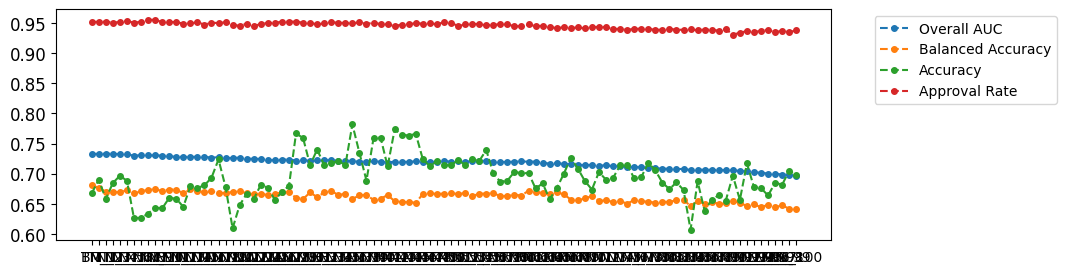

In [ ]:
#@title Show evolution of metrics

metrics_df = metrics.copy()#_techniques.copy()

# Set the desired figure size
plt.figure(figsize=(10, 3))

cols_to_plot =  ['Overall AUC', 'Balanced Accuracy', 'Accuracy', 'Approval Rate']
cols_plotted = []

# Iterate over the columns of metrics_df.T and create individual plots
for m in cols_to_plot:
    if m in metrics_df.T.columns:
        plt.plot(metrics_df.T[m], marker='o', markersize=4, linestyle='--')
        cols_plotted.append(m)

# Add a legend outside the loop
plt.legend(cols_plotted, loc='upper right', bbox_to_anchor=(.8, 0.5, 0.5, 0.5))

# Set the y-axis tick positions and labels
plt.yticks(fontsize=12)

# Show the plots
plt.show()

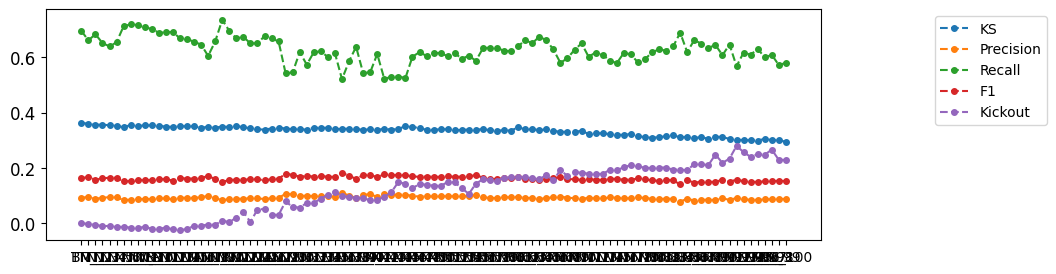

In [ ]:
#@title Show evolution of metrics
# Set the desired figure size
plt.figure(figsize=(10, 3))

cols_to_plot = ['KS','Precision', 'Recall','F1', 'Kickout']
cols_plotted = []

# Iterate over the columns of metrics.T and create individual plots
for m in cols_to_plot:
    if m in metrics_df.T.columns:
        plt.plot(metrics_df.T[m], marker='o', markersize=4, linestyle='--')
        cols_plotted.append(m)

# Add a legend outside the loop
plt.legend(cols_plotted, loc='upper right', bbox_to_anchor=(.8, 0.5, 0.5, 0.5))

# Set the y-axis tick positions and labels
plt.yticks(fontsize=12)

# Show the plots
plt.show()